### Day 7 - Tiled matmul experiments

- Benchmark it against Numpy and naive matmul
- Benchmark the impact of boundary checks on performance.

In [ ]:
import numpy as np
from PIL import Image
from pathlib import Path

In [ ]:
import pycuda.driver as cuda
from pycuda.compiler import SourceModule
cuda.init()

device = cuda.Device(0)

print(f"Cuda version: {".".join([str(i) for i in cuda.get_version()])}")
print(f"Device:\t{device.name()}")

Cuda version: 12.8.0
Device:	NVIDIA GeForce RTX 3080 Laptop GPU


In [ ]:
cu_file="kernels/matmul/matmul-tiled-experiments.cu"

In [ ]:
#|output: asis
#|echo: false


c_code = Path(cu_file).read_text()
print(f'''

### [{cu_file}](https://github.com/xl0/cuda-100/blob/master/nbs/{cu_file})

::: {{.sourceCode}}
```cpp
{c_code}
```
:::
''')



### [kernels/matmul/matmul-tiled-experiments.cu](https://github.com/xl0/cuda-100/blob/master/nbs/kernels/matmul/matmul-tiled-experiments.cu)

::: {.sourceCode}
```cpp
#include <stdint.h>
#include <stdio.h>


#ifndef TILE_WIDTH
#define TILE_WIDTH 16
#endif

__global__ void matmul_fp32_tiled_bc(float* m1, float* m2, float* res,
                                     uint32_t out_shape_0,
                                     uint32_t out_shape_1,
                                     uint32_t inner_dim,
                                     uint32_t) {

    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;

    __shared__ float m1_tile[TILE_WIDTH][TILE_WIDTH];
    __shared__ float m2_tile[TILE_WIDTH][TILE_WIDTH];


    int m1_x = inner_dim;
    int m2_x = out_shape_1;

    if (x < out_shape_1 && y < out_shape_0) {
        float R = 0;
        for (int tile = 0; tile < inner_dim / TILE_WIDTH; tile++) {

            m1_tile[threadIdx.y][threadId

In [ ]:
from lovely_numpy import Lo

In [ ]:
m1 = np.random.randn(513, 1024).astype(np.float32)
m2 = np.random.randn(1024, 8000).astype(np.float32)

np_res = np.matmul(m1, m2)
Lo(np_res)

array[513, 8000] f32 n=4104000 (16Mb) x∈[-170.506, 157.441] μ=0.035 σ=31.994

In [ ]:
## Compiler options for more compile-time warnings.
warn_options=[
    '-Xcompiler', '-Wall',
    '-Xcompiler', '-Wextra',
    '-Xcompiler', '-Wsign-conversion',
    '-Xcompiler', '-Wcast-qual',
    '-Xcompiler', '-Wunused-parameter',
    '-Xcompiler', '-Wdouble-promotion',
    '-Xcompiler', '-Wformat=2',
    '-Xcompiler', '-Wfloat-equal',
    '-Xcompiler', '-Wshadow'
]

In [ ]:
def benchmark_matmul(file, kernel_name, m1, m2, tile_width=16, repeat=100):

    assert len(m1.shape) == 2
    assert len(m2.shape) == 2
    assert m1.shape[1] == m2.shape[0]

    out_shape = (m1.shape[0], m2.shape[1])

    try:
        ctx = device.make_context()

        mod = SourceModule(
            Path(file).read_text(),
            options=warn_options + [
                f"-D TILE_WIDTH={tile_width}",
                ])

        kernel = mod.get_function(kernel_name)

        gpu_m1 = cuda.mem_alloc_like(m1)
        gpu_m2 = cuda.mem_alloc_like(m2)

        res = np.empty(out_shape, dtype=np.float32)

        cuda.memcpy_htod(gpu_m1, m1)
        cuda.memcpy_htod(gpu_m2, m2)

        block_size = (tile_width, tile_width, 1)
        grid_size = (
            ((out_shape[1] + tile_width - 1) // tile_width),
            ((out_shape[0] + tile_width - 1) // tile_width),
            1
        )


        print(f"Matrix 1 shape: {m1.shape}")
        print(f"Matrix 2 shape: {m2.shape}")
        print(f"Result shape: {out_shape}")
        print(f"Grid size: {grid_size}")
        print(f"Block size: {block_size}")
        print(f"Total threads: {grid_size[0] * grid_size[1] * block_size[0] * block_size[1]}")


        ctx.synchronize()

        timing=0
        for _ in range(repeat):
            start = cuda.Event()
            end = cuda.Event()

            gpu_res = cuda.mem_alloc_like(res)

            kernel(gpu_m1, gpu_m2, gpu_res, np.uint32(out_shape[0]), np.uint32(out_shape[1]), np.uint32(m1.shape[1]), grid=grid_size, block=block_size)

            start.record()
            kernel(gpu_m1, gpu_m2, gpu_res, np.uint32(out_shape[0]), np.uint32(out_shape[1]), np.uint32(m1.shape[1]), grid=grid_size, block=block_size)
            end.record()

            cuda.memcpy_dtoh(res, gpu_res)

            timing += end.time_since(start)
        timing /= repeat


    finally:
        ctx.pop()
        ctx.detach()
    return res, timing


res, timing = benchmark_matmul(cu_file, "matmul_fp32_tiled_bc", m1, m2, 16, repeat=10)
print(Lo(res))
print(f"Took {timing:.3f}ms")

Matrix 1 shape: (513, 1024)
Matrix 2 shape: (1024, 8000)
Result shape: (513, 8000)
Grid size: (500, 33, 1)
Block size: (16, 16, 1)
Total threads: 4224000
array[513, 8000] f32 n=4104000 (16Mb) x∈[-170.506, 157.441] μ=0.032 σ=31.975
Took 9.715ms


In [ ]:
np.isclose(res, np_res).mean()

np.float64(0.9766790935672515)

### Experiment with tile width

In [ ]:
import pandas as pd
from tqdm.auto import tqdm

In [ ]:
import random

In [ ]:
data = []

repeat = 3

def time_kernel(ctx, kernel, tile_size, matrix_size, repeat=5):
    out_shape = (matrix_size, matrix_size)

    m1 = np.random.randn(matrix_size, matrix_size).astype(np.float32)
    m2 = np.random.randn(matrix_size, matrix_size).astype(np.float32)

    res = np.empty_like(m1)


    gpu_m1 = cuda.mem_alloc_like(m1)
    gpu_m2 = cuda.mem_alloc_like(m2)

    gpu_res = cuda.mem_alloc_like(res)

    block_size = (tile_size, tile_size, 1)
    grid_size = (
        ((out_shape[1] + tile_size - 1) // tile_size),
        ((out_shape[0] + tile_size - 1) // tile_size),
        1
    )

    # warmup run, just in case
    kernel(gpu_m1, gpu_m2, gpu_res, np.uint32(out_shape[0]), np.uint32(out_shape[1]), np.uint32(m1.shape[1]), grid=grid_size, block=block_size)


    timing = 0
    for _ in range(repeat):
        start = cuda.Event()
        end = cuda.Event()


        start.record()
        kernel(gpu_m1, gpu_m2, gpu_res, np.uint32(out_shape[0]), np.uint32(out_shape[1]), np.uint32(m1.shape[1]), grid=grid_size, block=block_size)
        end.record()
        end.synchronize()

        timing += end.time_since(start)
    timing /= repeat

    return timing



# for tile_size in tqdm([32, 24, 16, 12, 8, 4]):
for tile_size in tqdm([4, 8, 16, 32]):
    ctx = device.make_context()

    mod = SourceModule(
        Path(cu_file).read_text(),
        options=warn_options + [
            f"-D TILE_WIDTH={tile_size}"
            ])

    kernel_bc = mod.get_function("matmul_fp32_tiled_bc")
    kernel_nc = mod.get_function("matmul_fp32_tiled")


    n = 0

    for matrix_size in tqdm(range(64,8192, 32)):
        timing = time_kernel(ctx, kernel_nc, tile_size, matrix_size, repeat)

        data.append({
            "matrix_size": matrix_size,
            "tile_size": tile_size,
            "timing_nc": timing
        })

        n += 1
        if timing > 300: break # We increase the size of the matrix until it gets too slow

    # Sample a few matrix sizes that are not multiple of tile size
    for _ in tqdm(range(n)):

        # Generate a random matrix size that is not multiple of tile size
        matrix_size = 32
        while not matrix_size % tile_size:
            matrix_size = random.randint(1, n*32)

        timing = time_kernel(ctx, kernel_bc, tile_size, matrix_size, repeat)

        data.append({
            "matrix_size": matrix_size,
            "tile_size": tile_size,
            "timing_bc": timing
        })



  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

### Let's also time the naive matmul implementation

In [ ]:

def time_naive_matmul(ctx, kernel, size, repeat=5):

    BLOCK_SIZE=32

    out_shape = (size, size)

    m1 = np.random.randn(matrix_size, matrix_size).astype(np.float32)
    m2 = np.random.randn(matrix_size, matrix_size).astype(np.float32)

    gpu_m1 = cuda.mem_alloc_like(m1)
    gpu_m2 = cuda.mem_alloc_like(m2)

    res = np.empty(out_shape, dtype=np.float32)

    gpu_res = cuda.mem_alloc_like(res)


    cuda.memcpy_htod(gpu_m1, m1)
    cuda.memcpy_htod(gpu_m2, m2)

    block_size = (BLOCK_SIZE, BLOCK_SIZE, 1)
    grid_size = (
        ((out_shape[1] + BLOCK_SIZE - 1) // BLOCK_SIZE),
        ((out_shape[0] + BLOCK_SIZE - 1) // BLOCK_SIZE),
        1
    )
    # warmup run, just in case
    kernel(gpu_m1, gpu_m2, gpu_res, np.uint32(out_shape[0]), np.uint32(out_shape[1]), np.uint32(m1.shape[1]), grid=grid_size, block=block_size)


    timing = 0
    for _ in range(repeat):
        start = cuda.Event()
        end = cuda.Event()


        start.record()
        kernel(gpu_m1, gpu_m2, gpu_res, np.uint32(out_shape[0]), np.uint32(out_shape[1]), np.uint32(m1.shape[1]), grid=grid_size, block=block_size)
        end.record()
        end.synchronize()

        timing += end.time_since(start)
    timing /= repeat
    return timing

In [ ]:
naive_d = []

try:
    ctx = device.make_context()

    mod = SourceModule(
        Path("kernels/matmul/matmul.cu").read_text(),
        options=warn_options)

    kernel = mod.get_function("matmul_f32")

    for matrix_size in tqdm(range(64, 8192, 32)):

        timing = time_naive_matmul(ctx, kernel, matrix_size)

        naive_d.append({
            "matrix_size": matrix_size,
            "timing_nc": timing
        })


finally:
    ctx.pop()
    ctx.detach()


  0%|          | 0/254 [00:00<?, ?it/s]

In [ ]:
import time

# Benchmark against numpy
numpy_data = []

for matrix_size in tqdm(range(64, 8192, 32)):
    # Create random matrices
    m1 = np.random.randn(matrix_size, matrix_size).astype(np.float32)
    m2 = np.random.randn(matrix_size, matrix_size).astype(np.float32)

    # Time numpy matmul
    timing = 0
    repeat = 3
    for _ in range(repeat):
        start_time = time.perf_counter()
        np.matmul(m1, m2)
        end_time = time.perf_counter()
        timing += (end_time - start_time) * 1000  # Convert to ms
    timing /= repeat

    numpy_data.append({
        "matrix_size": matrix_size,
        "timing_numpy": timing
    })



  0%|          | 0/254 [00:00<?, ?it/s]

In [ ]:
# data = [d for d in data if "tile_size" in d]

In [ ]:
# naive_d = [{
#     "matrix_size": matrix_size,
#     "timing_nc": timing
# } for matrix_size, timing in naive_d.items()]

AttributeError: 'list' object has no attribute 'items'

In [ ]:
# Create empty dataframe with matrix size as index
df = pd.DataFrame(index=sorted(list(set(d['matrix_size'] for d in data))))

# Add columns for each tile size and version
for tile_size in [4, 8, 16, 32]:
    # Get data for this tile size
    tile_data = [d for d in data if d['tile_size'] == tile_size]

    # Add bounds check timings
    bc_data = {d['matrix_size']: d['timing_bc'] for d in tile_data if 'timing_bc' in d}
    df[f'tile_{tile_size}_bc'] = pd.Series(bc_data)

    # Add no bounds check timings
    nc_data = {d['matrix_size']: d['timing_nc'] for d in tile_data if 'timing_nc' in d}
    df[f'tile_{tile_size}_nc'] = pd.Series(nc_data)

# Add naive matmul timings
naive_timing_data = {d['matrix_size']: d['timing_nc'] for d in naive_d}
df['naive'] = pd.Series(naive_timing_data)

# Add numpy timings
numpy_timing_data = {d['matrix_size']: d['timing_numpy'] for d in numpy_data}
df['numpy'] = pd.Series(numpy_timing_data)

In [ ]:
df

,tile_4_bc,tile_4_nc,tile_8_bc,tile_8_nc,tile_16_bc,tile_16_nc,tile_32_bc,tile_32_nc,naive,numpy
21,NaN,NaN,0.009899,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,NaN,NaN,0.013995,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27,0.016725,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30,NaN,NaN,0.020821,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36,NaN,NaN,NaN,NaN,0.017408,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
4992,NaN,NaN,NaN,NaN,NaN,281.592153,NaN,296.357890,376.128101,484.159823
5024,NaN,NaN,NaN,NaN,NaN,285.978963,NaN,302.391296,390.056757,491.502393
5056,NaN,NaN,NaN,NaN,NaN,291.479889,NaN,NaN,397.113953,491.477690
5088,NaN,NaN,NaN,NaN,NaN,299.429545,NaN,NaN,404.441296,510.304571


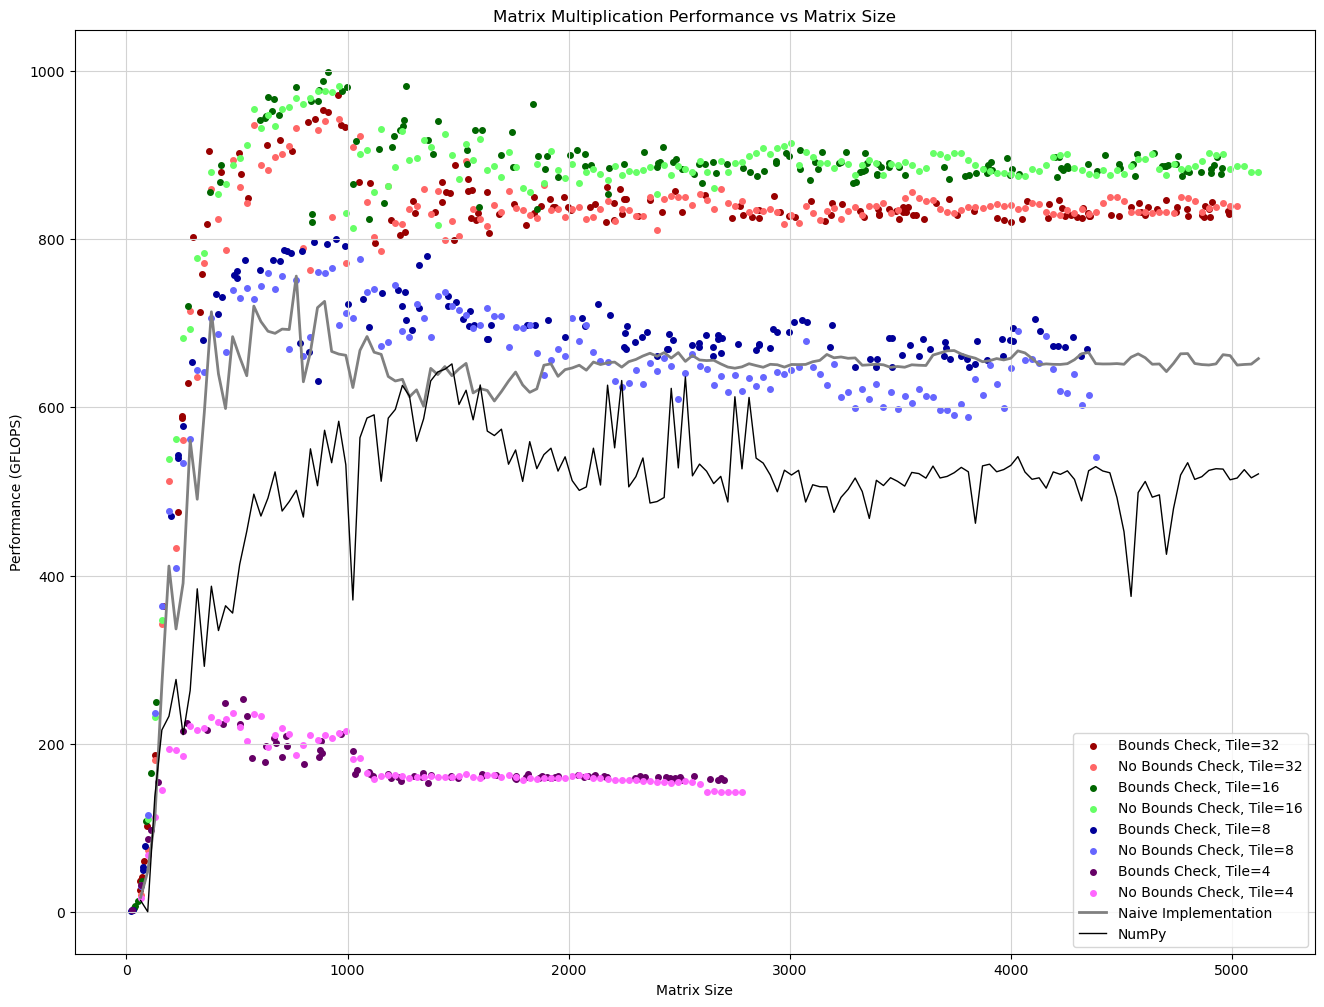

In [ ]:
import matplotlib.pyplot as plt

# Create figure
plt.figure(figsize=(16, 12))

# Define colors for each tile size - darker shade for bc, lighter for nc
colors = {
    32: ['#990000', '#ff6666'],  # Dark/light red
    16: ['#006600', '#66ff66'],  # Dark/light green
    8: ['#000099', '#6666ff'],   # Dark/light blue
    4: ['#660066', '#ff66ff']    # Dark/light purple
}

# Plot for each tile size in reverse order so larger tiles appear first in legend
for tile_size in [32, 16, 8, 4]:
    # Get data for this tile size from dataframe
    bc_col = f'tile_{tile_size}_bc'
    nc_col = f'tile_{tile_size}_nc'

    # Get matrix sizes and timings, dropping NaN values
    bc_data = df[bc_col].dropna()
    nc_data = df[nc_col].dropna()
    bc_matrix_sizes = bc_data.index
    nc_matrix_sizes = nc_data.index

    # Calculate GFLOPS
    bc_gflops = (2 * bc_matrix_sizes**3 * 1000) / (bc_data * 1_000_000_000)
    nc_gflops = (2 * nc_matrix_sizes**3 * 1000) / (nc_data * 1_000_000_000)

    # Plot bounds check data
    plt.scatter(bc_matrix_sizes, bc_gflops,
               label=f'Bounds Check, Tile={tile_size}',
               color=colors[tile_size][0],
               s=16)

    # Plot no bounds check data
    plt.scatter(nc_matrix_sizes, nc_gflops,
               label=f'No Bounds Check, Tile={tile_size}',
               color=colors[tile_size][1],
               s=16)

# Get naive data and calculate GFLOPS
naive_d = df['naive'].dropna()
naive_matrix_sizes = naive_d.index
naive_gflops = (2 * naive_matrix_sizes**3 * 1000) / (naive_d * 1_000_000_000)

# Plot naive data as a line
plt.plot(naive_matrix_sizes, naive_gflops,
         label='Naive Implementation',
         color='gray',
         linewidth=2)

# Get numpy data and calculate GFLOPS
numpy_d = df['numpy'].dropna()
numpy_matrix_sizes = numpy_d.index
numpy_gflops = (2 * numpy_matrix_sizes**3 * 1000) / (numpy_d * 1_000_000_000)

# Plot numpy data as a line
plt.plot(numpy_matrix_sizes, numpy_gflops,
         label='NumPy',
         color='black',
         linewidth=1)

plt.title('Matrix Multiplication Performance vs Matrix Size')
plt.xlabel('Matrix Size')
plt.ylabel('Performance (GFLOPS)')
plt.grid(True, color='lightgrey')
plt.legend();